<a href="https://colab.research.google.com/github/Besiroglu/computer_vision_data/blob/main/Computer_vision_15_nov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Algorithmic progress in computer vision: Colab notebook

This Colab notebook is meant to accompany "Algorithmic progress in computer vision". It contains the code you need to replicate the results of the paper yourself.

## Setup

First, we import the necessary modules that will be used throughout the notebook:

In [ ]:
%%capture
import pandas as pd
import autograd.numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors, cm
import statsmodels.api as sm
from autograd import grad, hessian
from scipy.stats import beta, gaussian_kde
from scipy.optimize import minimize, basinhopping
from copy import deepcopy
from IPython.display import display
from google.colab import files
import pickle
import warnings
from decimal import Decimal
import random
warnings.filterwarnings("error")
!pip install matplotlib-label-lines
import labellines

Now we define a few functions that will play important roles in the rest of the script. You can learn more about these functions by reading the comments attached to them.

In [ ]:
# this is just a vanilla sigmoid function
def sigmoid(x):
    return 1/(1 + np.exp(-x))

# inverse sigmoid function
def inv_sigmoid(x):
    return np.log(x/(1-x))

# transformation of performance/top-1 accuracy that we use for the first regression
def transform(x):
    return inv_sigmoid(x/(1 - ir))

correction = grad(transform)

# the log correction term we need to include when we go from the log likelihood of transform(P) to the log likelihood of P itself
def log_correction(x):
    return np.log(correction(x))

# the log pdf of the normal distribution with mean mu and standard deviation sigma
def norm_logpdf(x, mu=0, sigma=1):
    n = len(x)
    return -np.sum(np.log(sigma)) - n * np.log(2*np.pi)/2 - (1/2) * np.sum(((x - mu)/sigma)**2)

def norm_logpdf_scalar(x, mu=0, sigma=1):
    n = 1
    return -np.sum(np.log(sigma)) - n * np.log(2*np.pi)/2 - (1/2) * np.sum(((x - mu)/sigma)**2)

Upload this file with the specified name after running the cell below.

In [ ]:
df_ex = pd.read_csv('https://raw.githubusercontent.com/Besiroglu/computer_vision_data/main/imagenet.csv')

Finally, some data cleanup. This code excludes data points we don't want from the datasets above, e.g. data points with undefined final compute use estimates and data points which are reimplementations, and also adds a data column to the imagenet_v3 dataset to take into account the size of the ImageNet training set, which consists of 1.28 million images.

In [ ]:
df4 = df_ex[["url",	"publication_date",	"year",	"fractional_year", "model_name",	"extra_data",	"top_1_error",	"top_5_error",	"final_compute_estimate",	"nr_training_images",	"parameter_count", "reimplementation",	"input_size_test"]]
df4 = df4[df4["top_1_error"].notna() & df4["final_compute_estimate"].notna() & df4["parameter_count"].notna()]

exclude_models = ["GreedyNAS-B", "NASNet-A", "AmoebaNet-A"]

for model_name in exclude_models:
    df4 = df4[df4["model_name"] != model_name]

df4["data"] = df4["nr_training_images"]
df4["model_size"] = df4["parameter_count"]
df4["year"] = df4["fractional_year"]

df4

,url,publication_date,year,fractional_year,model_name,extra_data,top_1_error,top_5_error,final_compute_estimate,nr_training_images,parameter_count,reimplementation,input_size_test,data,model_size
0,https://arxiv.org/abs/1406.4729,6/18/2014,114.47,114.47,SPPNet,0,27.86,NaN,6.110000e+18,1.280000e+06,1.390000e+08,0,224.0,1.280000e+06,1.390000e+08
1,https://arxiv.org/abs/1409.1556,09/04/2014,114.68,114.68,"VGG-A,A-LRN",0,29.70,9.4,2.270000e+19,1.280000e+06,1.330000e+08,0,256.0,1.280000e+06,1.330000e+08
2,https://arxiv.org/abs/1409.1556,09/04/2014,114.68,114.68,VGG-19,0,25.50,8.0,1.020000e+19,1.280000e+06,1.440000e+08,0,384.0,1.280000e+06,1.440000e+08
3,https://arxiv.org/abs/1409.1557,09/04/2014,114.68,114.68,VGG-B,0,28.70,9.4,2.280000e+19,1.280000e+06,1.340000e+08,0,256.0,1.280000e+06,1.340000e+08
4,https://arxiv.org/abs/1409.1558,09/04/2014,114.68,114.68,VGG-C,0,28.10,9.4,2.270000e+19,1.280000e+06,1.330000e+08,0,256.0,1.280000e+06,1.330000e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,https://arxiv.org/pdf/1311.2901,11/12/2013,113.87,113.87,"ZFNet (ensemble, 6 convnets)",0,36.00,14.7,5.410000e+17,1.280000e+06,6.230000e+07,0,256.0,1.280000e+06,6.230000e+07
108,https://arxiv.org/pdf/1311.2901,11/12/2013,113.87,113.87,"ZFNet (ensemble, 5 convnets)",0,36.70,14.7,3.290000e+17,1.280000e+06,3.790000e+07,0,256.0,1.280000e+06,3.790000e+07
109,https://arxiv.org/pdf/2209.06794v2.pdf,9/16/2022,122.71,122.71,ViT-e,1,9.10,NaN,1.070000e+23,3.000000e+09,4.000000e+09,0,NaN,3.000000e+09,4.000000e+09
110,https://openreview.net/forum?id=YicbFdNTTy,9/28/2020,120.74,120.74,ViT-L/16,1,14.70,NaN,1.010000e+20,1.520000e+07,3.070000e+08,0,NaN,1.520000e+07,3.070000e+08


## Parameter estimates

### Single sigmoid regression without irreducible loss, whole dataset

This section is for the first regression model that uses only a single sigmoid term to model top 1 accuracy, with year, log data and log compute all contributing linearly to the argument of that single sigmoid.

In [ ]:
ir = 0 # irreducible loss estimate of ImageNet

df2 = df4.copy()
df2["top_1_error"] = df2["top_1_error"].apply(lambda p: 1 - p/100)
df2["performance"] = df2["top_1_error"]

df2["top_1_error"] = df2["top_1_error"].apply(transform)
df2["final_compute_estimate"] = df2["final_compute_estimate"].apply(np.log)
df2["data"] = df2["data"].apply(np.log)
df2["model_size"] = df2["model_size"].apply(np.log)

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)                      
    m2 = sm.OLS(endog = df2["top_1_error"], exog = sm.add_constant(df2[["year", "final_compute_estimate", "model_size", "data"]]))

r2 = m2.fit(cov_type="hac-panel", cov_kwds={"time": list(df2["year"]), "maxlags": 1})

res = r2

print(res.summary())
print("Log likelihood function over performance: %.2f" % (res.llf + np.sum([log_correction(p) for p in df2["performance"]])))

                            OLS Regression Results                            
Dep. Variable:            top_1_error   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     128.3
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           6.11e-06
Time:                        19:17:33   Log-Likelihood:                 68.344
No. Observations:                  97   AIC:                            -126.7
Df Residuals:                      92   BIC:                            -113.8
Df Model:                           4                                         
Covariance Type:            hac-panel                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    -11

### Main model

Now we fit the model where performance is modelled as a product of two sigmoids; one whose argument depends on log data and the other whose argument depends on the year and log compute. This section could take around 5 minutes to run, as I use basin hopping to optimize the log likelihood and bootstrap 100 different random samples from the dataset to get standard error estimates on the parameters.

In [ ]:
w = len(df4)
steps = 100
np.random.seed(1)
               
sigma_constants = 1  #based on cross-validation exercises
sigma_exponents = 0.09 #based on cross-validation exercises

df2 = df4.copy()
df2["top_1_error"] = df2["top_1_error"].apply(lambda p: p/100)
df2["performance"] = df2["top_1_error"].apply(lambda p: 1 - p)

df_random_list = [df2.iloc[np.random.choice(range(w), size=w)] for _ in range(steps-1)]

ir = 0 # this variable should always be set to zero in this part of the script! otherwise the log likelihood corrections will be computed incorrectly

params_table = {"const_year": [], "beta_year": [], "beta_compute": [], "const_data": [], "beta_data": [], "beta_year_2": [], "sigma": []}
log_likelihoods = []

def regularizer(params):
   [const_year, beta_year, beta_compute, const_data, beta_data, beta_year_2, sigma] = params
   return norm_logpdf(params, mu = [0, 0, 0, 0, 0, 0, 0], sigma = [sigma_constants, sigma_exponents, sigma_exponents, sigma_constants, sigma_exponents, sigma_exponents, sigma_constants])

def bootstrap_third_alternative(df_random_list, random=True, i=0):
    if random:
        df_random = df_random_list[i]
    else:
        df_random = df2

    error = np.array(df_random["top_1_error"], dtype=float)
    performance = 1 - error
    year = np.array(df_random["year"], dtype=float)
    compute = np.array(df_random["final_compute_estimate"], dtype=float)
    data = np.array(df_random["data"], dtype=float)

    n = len(error)

    def loss(params):
        [const_year, beta_year, beta_compute, const_data, beta_data, beta_year_2, sigma] = params
        sigma = np.exp(sigma)

        first_arg = const_year + beta_year * (year - 112) + beta_compute * (np.log(compute) - np.log(4.7e+17))
        second_arg = const_data + beta_year_2 * (year - 112) + beta_data * (np.log(data) - np.log(1e+6))
                                                                                        
        rval = -norm_logpdf(inv_sigmoid(performance), mu = inv_sigmoid(sigmoid(first_arg) * sigmoid(second_arg)), \
                                                      sigma = np.array([sigma] * n))/len(performance) \
               -regularizer(params)/len(performance)

        return rval

    grad_loss = grad(loss)
    hess_loss = hessian(loss)
                                                  
    res = basinhopping(loss, x0=[1, 1e-1, 1e-1, 1, 1e-1, 1e-1, -3], minimizer_kwargs = {"method": "trust-ncg", "tol": 1e-10, "jac": grad_loss, "hess": hess_loss}, niter=2)
    return res, (-res.fun * len(performance) + np.sum([log_correction(p) for p in performance]))

steps = 100

for i in range(steps):
    res, llf = bootstrap_third_alternative(df_random_list, (i != 0), i-1)
    const_year, beta_year, beta_compute, const_data, beta_data, beta_year_2, sigma = res.x

    params_table["const_year"].append(const_year)
    params_table["beta_year"].append(beta_year)
    params_table["beta_year_2"].append(beta_year_2)
    params_table["beta_compute"].append(beta_compute)
    params_table["const_data"].append(const_data)
    params_table["beta_data"].append(beta_data)
    params_table["sigma"].append(sigma)

    log_likelihoods.append(llf - regularizer(res.x))

    if i % 5 == 4:
      print("Bootstrap steps complete: (%d/%d)" % (i+1, steps))

print("Bootstrapping complete!")

params_table_fin = deepcopy(params_table)
log_likelihoods_fin = deepcopy(log_likelihoods)

Bootstrap steps complete: (5/100)
Bootstrap steps complete: (10/100)
Bootstrap steps complete: (15/100)
Bootstrap steps complete: (20/100)
Bootstrap steps complete: (25/100)
Bootstrap steps complete: (30/100)
Bootstrap steps complete: (35/100)
Bootstrap steps complete: (40/100)
Bootstrap steps complete: (45/100)
Bootstrap steps complete: (50/100)
Bootstrap steps complete: (55/100)
Bootstrap steps complete: (60/100)
Bootstrap steps complete: (65/100)
Bootstrap steps complete: (70/100)
Bootstrap steps complete: (75/100)
Bootstrap steps complete: (80/100)
Bootstrap steps complete: (85/100)
Bootstrap steps complete: (90/100)
Bootstrap steps complete: (95/100)
Bootstrap steps complete: (100/100)
Bootstrapping complete!


This cell is for displaying the results of the above computation. Running it will get you a table showing parameter names, point estimates and standard errors for all of the model parameters, along with the log likelihood the model achieves on the whole dataset.

Specifically, the log likelihood achieved by this model is around 6.5 nats above the log likelihood achieved by the first regression model, which is an improvement significant enough to justify this model's use of 6 parameters over the first model's 5 parameters.

Note that the sigma parameter is the logarithm of the standard deviation of the error term of the model, which is additive in log odds space. It's an important parameter as it represents the extent to which the model is uncertain about its performance estimates.

In [ ]:
table = pd.DataFrame({"Parameters": [key for key in params_table] + ["Log likelihood", "Mean log likelihood", "Dataset size"], \
                      "Point estimates": [params_table[key][0] for key in params_table] + [log_likelihoods[0], log_likelihoods[0]/len(df2), len(df2)], \
                      "Standard errors": [np.std(params_table[key]) for key in params_table] + [None, None, None], \
                      "5th percentile": [np.percentile(params_table[key], 2.5) for key in params_table] + [None, None, None], \
                      "95th percentile": [np.percentile(params_table[key], 97.5) for key in params_table] + [None, None, None]})
display(table)

#print("Log likelihood function over performance: %.2f" % log_likelihoods[0])

,Parameters,Point estimates,Standard errors,5th percentile,95th percentile
0,const_year,0.889338,0.294813,0.606529,1.981479
1,beta_year,0.158895,0.043217,0.012517,0.212297
2,beta_compute,0.154499,0.043288,0.070176,0.249275
3,const_data,1.782682,0.306655,1.118821,2.308797
4,beta_data,0.063199,0.014753,0.048043,0.104872
5,beta_year_2,0.019822,0.037169,-0.031772,0.132078
6,sigma,-2.160454,0.084388,-2.394913,-2.081804
7,Log likelihood,267.062746,NaN,NaN,NaN
8,Mean log likelihood,2.753224,NaN,NaN,NaN
9,Dataset size,97.000000,NaN,NaN,NaN


## Visualizations

## Main results

This cell sets up the functions that will be used to produce the visualizations later on in the section.

In [ ]:
params_list = []
for i in range(len(params_table_fin["const_year"])):
    params_list.append([params_table_fin[key][i] for key in params_table_fin])

def accuracy_model(year_data, year_compute, data, compute, noisy=False):
    if noisy:
        r = []
        for param in params_list:
            const_year, beta_year, beta_compute, const_data, beta_data, beta_year_2, sigma = param

            first_arg = const_year + beta_compute * (np.log(compute) - np.log(4.7e+17)) + beta_year * (year_compute - 112)
            second_arg = const_data + beta_data * (np.log(data) - np.log(1e+6)) + beta_year_2 * (year_data - 112)
            
            r.append(sigmoid(inv_sigmoid(sigmoid(first_arg) * sigmoid(second_arg)) + np.random.normal(loc=0, scale=np.exp(sigma))))
        return r
    else:
        const_year, beta_year, beta_compute, const_data, beta_data, beta_year_2, sigma = params_list[0]

        first_arg = const_year + beta_compute * (np.log(compute) - np.log(4.7e+17)) + beta_year * (year_compute - 112)
        second_arg = const_data + beta_data * (np.log(data) - np.log(1e+6)) + beta_year_2 * (year_data - 112)

        return sigmoid(first_arg) * sigmoid(second_arg)

from scipy.optimize import fsolve

def compute_required(year, data, performance):
    year -= 1900

    def obj(log_compute):
        return accuracy_model(year, year, data, np.exp(log_compute)) - performance
    x, infodict, ier, mesg = fsolve(obj, fprime=grad(obj), x0 = np.log(1e+20), full_output=True)
    if ier == 1:
      return np.exp(x[0])
    else:
      return float("inf")

def data_required(year, compute, performance):
    year -= 1900
    
    def obj(log_data):
        return accuracy_model(year, year, np.exp(log_data), compute) - performance
    x, infodict, ier, mesg = fsolve(obj, fprime=grad(obj), x0 = np.log(1e+6), full_output=True)
    if ier == 1:
        return np.exp(x[0])
    else:
        return float("inf")

def pareto_frontier(year, performance, min_data=1e+4, max_data=1e+12, num_samples=400):
    x = []
    y = []

    for log_data in np.linspace(np.log(max_data), np.log(min_data), num_samples):
      compute = compute_required(year, np.exp(log_data), performance)
      if compute == float("inf"):
        break
      else:
        x.append(np.exp(log_data))
        y.append(compute)
    return x, y

In [ ]:
accuracy_model(2021.8054794520547945 - 1900, 2021.8054794520547945 - 1900, 3.30E+09, 8.81E+21)

0.9062246048726437

### Quantifying improvement

The function below treats obtaining good model performance as a coalition game and computes the fraction of improvement due to different factors between two endpoints using a Shapley value calculation.

In [ ]:
from itertools import permutations

identity = lambda x:  x

def shapley_values(p1, p2, transform=identity):
    (year_data_start, year_compute_start, data_start, compute_start) = p1
    (year_data_end, year_compute_end, data_end, compute_end) = p2

    total_value = transform(accuracy_model(*p2)) \
                  - transform(accuracy_model(*p1))
    n = len(p1)
    values = [0] * n

    pi_list = list(permutations(range(n)))

    for pi in pi_list:
       q1 = list(p1)
       for k in pi:
          q2 = deepcopy(q1)
          q2[k] = p2[k]

          values[k] += (transform(accuracy_model(*q2)) - transform(accuracy_model(*q1)))/(total_value * len(pi_list))

          q1 = q2

    return values

The cell below attributes the performance improvement between the models in the given list of models to the three different factors using the function defined above.

In [ ]:
models = [((2012.94246 - 1900, 2012.94246 - 1900, 1.28e+6, 4.7e+17), "AlexNet"),
          ((2015.96164 - 1900, 2015.96164 - 1900, 1.28e+6, 2.92e+18),"ResNet-50"),
          ((2016.978 - 1900, 2016.978 - 1900, 1.28e+6, 3.07e+18),"ResNeXt-101"),
          ((2019.96986301 - 1900, 2019.96986301 - 1900, 3.00E+08, 8.79E+21), "BiT-L"),
          ((2020.8767123 - 1900, 2020.8767123 - 1900, 3.06e+08, 7.40E+21), "VIT-H/14"),
          ((2022.33972603 - 1900, 2022.33972603 - 1900, 3.30E+09, 1.07E+23), "VIT-e")]

        #Add COATNET and ViT-MoE-15B (Every-2)

for m in models:
    print("Predicted accuracy of %s: %.3f" % (m[1], accuracy_model(*(m[0]))))

for i in range(len(models)):
    for j in range(i+1, len(models)):
        print("------")
        print("Comparing %s with %s:" % (models[i][1], models[j][1]))
        improv_id = shapley_values(models[i][0], models[j][0], transform=identity)
        improv_sig = shapley_values(models[i][0], models[j][0], transform=inv_sigmoid)

        print("\n")
        print("In linear space, fraction of improvement due to...")
        print("Data efficiency: %.3f - Compute efficiency: %.3f - Data: %.3f - Compute: %.3f" % tuple(improv_id))

        print("\n")
        print("In log odds space, fraction of improvement due to...")
        print("Data efficiency: %.3f - Compute efficiency: %.3f - Data: %.3f - Compute: %.3f" % tuple(improv_sig))

Predicted accuracy of AlexNet: 0.635
Predicted accuracy of ResNet-50: 0.744
Predicted accuracy of ResNeXt-101: 0.763
Predicted accuracy of BiT-L: 0.887
Predicted accuracy of VIT-H/14: 0.890
Predicted accuracy of VIT-e: 0.913
------
Comparing AlexNet with ResNet-50:


In linear space, fraction of improvement due to...
Data efficiency: 0.052 - Compute efficiency: 0.597 - Data: 0.000 - Compute: 0.351


In log odds space, fraction of improvement due to...
Data efficiency: 0.053 - Compute efficiency: 0.597 - Data: 0.000 - Compute: 0.351
------
Comparing AlexNet with ResNeXt-101:


In linear space, fraction of improvement due to...
Data efficiency: 0.059 - Compute efficiency: 0.647 - Data: 0.000 - Compute: 0.293


In log odds space, fraction of improvement due to...
Data efficiency: 0.061 - Compute efficiency: 0.647 - Data: 0.000 - Compute: 0.292
------
Comparing AlexNet with BiT-L:


In linear space, fraction of improvement due to...
Data efficiency: 0.049 - Compute efficiency: 0.359 - Data

Compute requirements halving time

In [ ]:
beta_compute = params_table['beta_compute']
beta_year = params_table['beta_year']
res = []
for i in range(100): 
    res.append(12*np.log(2)*beta_compute[i]/beta_year[i])
print("Mean doubling time (months)")
print(np.mean(res))

print("\n")
print("Standard error doubling time")
print(np.std(res))
print("\n")
print("95% CI:")
print(np.percentile(res, 2.5))
print(np.percentile(res, 97.5))

Mean doubling time (months)
8.70575085822116


Standard error doubling time
9.791249473710188


95% CI:
3.5553921875846894
25.400800201046316


Calculate marginal increase in data and compute per year

In [ ]:
beta_compute = params_table['beta_compute']
beta_year = params_table['beta_year']
beta_data = params_table['beta_data']
beta_year_2 = params_table['beta_year_2']

res_compute = []
res_data = []
for i in range(100): 
    res_compute.append(beta_year[i]/beta_compute[i])
print("Marginal yearly increase in effective compute")
print(100*np.mean(res_compute))
print("95% CI:")
print(100*np.percentile(res_compute, 2.5))
print(100*np.percentile(100*res_compute, 97.5))


for i in range(100): 
    res_data.append(beta_year_2[i]/beta_data[i])
print("Marginal yearly increase in effective data")
print(100*np.mean(res_data))
print("95% CI:")
print(100*np.percentile(res_data, 2.5))
print(100*np.percentile(res_data, 97.5))

Marginal yearly increase in effective compute
100.95854345633124
95% CI:
24.600899558068523
215.18324097589962
Marginal yearly increase in effective data
37.6395079170889
95% CI:
-46.95285897782938
134.458229253898


In [ ]:
models = [((2012.94246 - 1900, 2012.94246 - 1900, 1.28e+6, 4.7e+17), "AlexNet"),
          ((2015.96164 - 1900, 2015.96164 - 1900, 1.28e+6, 2.92e+18),"ResNet-50"),
          ((2016.978 - 1900, 2016.978 - 1900, 1.28e+6, 3.07e+18),"ResNeXt-101"),
          ((2019.96986301 - 1900, 2019.96986301 - 1900, 3.00E+08, 8.79E+21), "BiT-L"),
          ((2020.8767123 - 1900, 2020.8767123 - 1900, 3.06e+08, 7.40E+21), "VIT-H/14"),
          ((2021.53698 - 1900, 2021.53698 - 1900, 3.06E+08, 5.89E+22), "ViT-MoE-15B (Every-2)"),
          ((2021.8054794520547945 - 1900, 2021.8054794520547945 - 1900, 3.30E+09, 8.81E+21), "CoAtNet-7"),
          ((2022.33972603 - 1900, 2022.33972603 - 1900, 3.30E+09, 1.07E+23), "VIT-e")]

algorithmic_progress = []
compute_scaling = []

for i in range(len(models)):
    for j in range(i+1, len(models)):
        improv_id = shapley_values(models[i][0], models[j][0], transform=inv_sigmoid)
        algorithmic_progress.append(improv_id[1])
        compute_scaling.append(improv_id[3])

k=-1
print("CE(M_1 → M_2):")
for i in range(len(models)):
    for j in range(i+1, len(models)): 
      k= k+1
      print(models[i][1], "→", models[j][1], ":", '%.2E' % Decimal((models[j][0][3]/models[i][0][3])**(algorithmic_progress[k]/compute_scaling[k])))

k=-1
print("\n")
print("T(M_1 → M_2):")
for i in range(len(models)):
    for j in range(i+1, len(models)): 
      k= k+1
      q=(models[j][0][3]/models[i][0][3])**(algorithmic_progress[k]/compute_scaling[k]) 
      expon= 1/(models[j][0][0]-models[i][0][0])
      g= q**expon
      print(models[i][1], "→", models[j][1], ":", round(12*np.log(2)/(np.log(g)),2) )

CE(M_1 → M_2):
AlexNet → ResNet-50 : 2.24E+01
AlexNet → ResNeXt-101 : 6.41E+01
AlexNet → BiT-L : 1.41E+03
AlexNet → VIT-H/14 : 3.56E+03
AlexNet → ViT-MoE-15B (Every-2) : 7.54E+03
AlexNet → CoAtNet-7 : 9.19E+03
AlexNet → VIT-e : 1.73E+04
ResNet-50 → ResNeXt-101 : 2.84E+00
ResNet-50 → BiT-L : 6.45E+01
ResNet-50 → VIT-H/14 : 1.64E+02
ResNet-50 → ViT-MoE-15B (Every-2) : 3.54E+02
ResNet-50 → CoAtNet-7 : 4.24E+02
ResNet-50 → VIT-e : 8.22E+02
ResNeXt-101 → BiT-L : 2.27E+01
ResNeXt-101 → VIT-H/14 : 5.81E+01
ResNeXt-101 → ViT-MoE-15B (Every-2) : 1.25E+02
ResNeXt-101 → CoAtNet-7 : 1.51E+02
ResNeXt-101 → VIT-e : 2.93E+02
BiT-L → VIT-H/14 : 2.54E+00
BiT-L → ViT-MoE-15B (Every-2) : 5.02E+00
BiT-L → CoAtNet-7 : 6.59E+00
BiT-L → VIT-e : 1.14E+01
VIT-H/14 → ViT-MoE-15B (Every-2) : 1.98E+00
VIT-H/14 → CoAtNet-7 : 2.60E+00
VIT-H/14 → VIT-e : 4.53E+00
ViT-MoE-15B (Every-2) → CoAtNet-7 : 1.32E+00
ViT-MoE-15B (Every-2) → VIT-e : 2.28E+00
CoAtNet-7 → VIT-e : 1.74E+00


T(M_1 → M_2):
AlexNet → ResNet-50 : 8.

Data requirements halving time

In [ ]:
models = [((2012.94246 - 1900, 2012.94246 - 1900, 1.28e+6, 4.7e+17), "AlexNet"),
          ((2015.96164 - 1900, 2015.96164 - 1900, 1.28e+6, 2.92e+18),"ResNet-50"),
          ((2016.978 - 1900, 2016.978 - 1900, 1.28e+6, 3.07e+18),"ResNeXt-101"),
          ((2019.96986301 - 1900, 2019.96986301 - 1900, 3.00E+08, 8.79E+21), "BiT-L"),
          ((2020.8767123 - 1900, 2020.8767123 - 1900, 3.06e+08, 7.40E+21), "VIT-H/14"),
          ((2021.53698 - 1900, 2021.53698 - 1900, 3.06E+08, 5.89E+22), "ViT-MoE-15B (Every-2)"),
          ((2021.8054794520547945 - 1900, 2021.8054794520547945 - 1900, 3.30E+09, 8.81E+21), "CoAtNet-7"),
          ((2022.33972603 - 1900, 2022.33972603 - 1900, 3.30E+09, 1.07E+23), "VIT-e")]

        #Add COATNET and ViT-MoE-15B (Every-2)

algorithmic_progress = []
data_scaling = []

for i in range(len(models)):
    for j in range(i+1, len(models)):
        improv_id = shapley_values(models[i][0], models[j][0], transform=identity)
        algorithmic_progress.append(improv_id[0])
        data_scaling.append(improv_id[2])

k=-1
print("CE(M_1 → M_2):")
for i in range(len(models)):
    for j in range(i+1, len(models)): 
      k= k+1
      if data_scaling[k] >0:
        print(models[i][1], "→", models[j][1], ":", '%.2E' % Decimal((models[j][0][2]/models[i][0][2])**(algorithmic_progress[k]/data_scaling[k])))

k=-1
print("\n")
print("T(M_1 → M_2):")
for i in range(len(models)):
    for j in range(i+1, len(models)): 
      k= k+1
      if data_scaling[k] >0:
        q=(models[j][0][2]/models[i][0][2])**(algorithmic_progress[k]/data_scaling[k]) 
        expon= 1/(models[j][0][0]-models[i][0][0])
        g= q**expon
        print(models[i][1], "→", models[j][1], ":", 12*np.log(2)/(np.log(g)))

CE(M_1 → M_2):
AlexNet → BiT-L : 9.06E+00
AlexNet → VIT-H/14 : 1.20E+01
AlexNet → ViT-MoE-15B (Every-2) : 1.48E+01
AlexNet → CoAtNet-7 : 1.62E+01
AlexNet → VIT-e : 1.92E+01
ResNet-50 → BiT-L : 3.52E+00
ResNet-50 → VIT-H/14 : 4.68E+00
ResNet-50 → ViT-MoE-15B (Every-2) : 5.76E+00
ResNet-50 → CoAtNet-7 : 6.31E+00
ResNet-50 → VIT-e : 7.47E+00
ResNeXt-101 → BiT-L : 2.56E+00
ResNeXt-101 → VIT-H/14 : 3.41E+00
ResNeXt-101 → ViT-MoE-15B (Every-2) : 4.19E+00
ResNeXt-101 → CoAtNet-7 : 4.59E+00
ResNeXt-101 → VIT-e : 5.43E+00
BiT-L → VIT-H/14 : 1.33E+00
BiT-L → ViT-MoE-15B (Every-2) : 1.63E+00
BiT-L → CoAtNet-7 : 1.78E+00
BiT-L → VIT-e : 2.10E+00
VIT-H/14 → CoAtNet-7 : 1.34E+00
VIT-H/14 → VIT-e : 1.58E+00
ViT-MoE-15B (Every-2) → CoAtNet-7 : 1.09E+00
ViT-MoE-15B (Every-2) → VIT-e : 1.29E+00


T(M_1 → M_2):
AlexNet → BiT-L : 26.527070574909846
AlexNet → VIT-H/14 : 26.52326935432716
AlexNet → ViT-MoE-15B (Every-2) : 26.52239977927997
AlexNet → CoAtNet-7 : 26.46629207239787
AlexNet → VIT-e : 26.4670383

### Pareto frontiers

Running this cell will plot the Pareto frontiers in data versus compute space for training a model with various levels of accuracy on ImageNet. Darker colors correspond to frontiers in earlier years, and the frontiers range from 2012 to 2022 inclusive. Algorithmic progress is captured by the fact that the frontier is shifting inwards.

Keep in mind that these frontiers are obtained by setting the error term in the model to zero. In fact it's possible for accuracy to be better than the model predicts, so an asymptote of the Pareto frontiers should not be taken to mean that it's impossible to train a model with the specified level of accuracy without being to the right of the Pareto frontier. The frontier is only the place where the given accuracy is the point estimate for the resources being spent.

**Note:** Create a folder named "visuals" from the Files tab so that the script is able to save the created figures as pdf files!

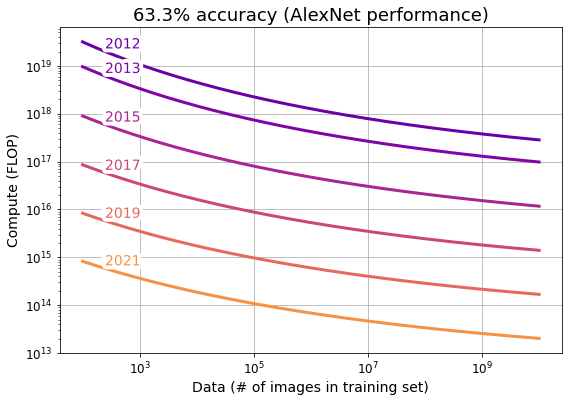

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

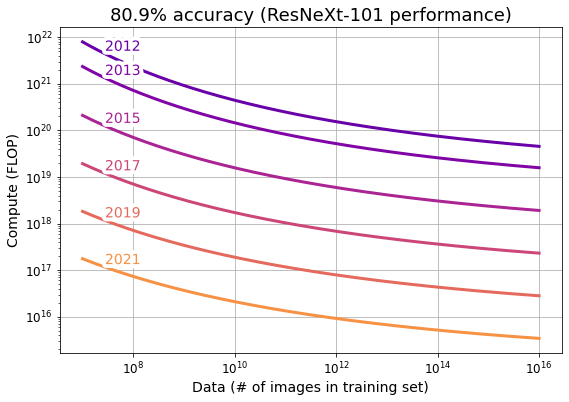

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

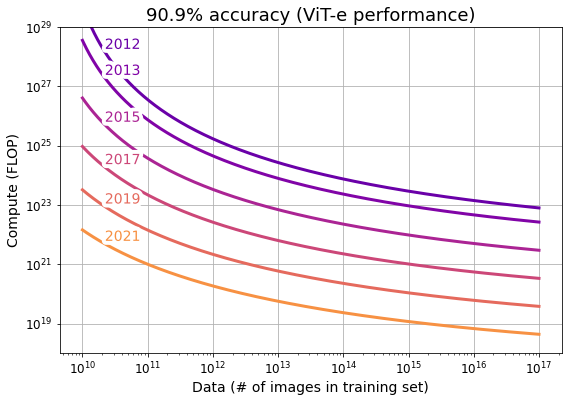

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
what_to_plot = [
    {"title": "63.3% accuracy (AlexNet performance)",
     "performance": 0.633,
     "cmap": "plasma",
     "min_data": 1e+2,
     "max_data": 1e+10,
     "filename": "alexnet"},
    {"title": "80.9% accuracy (ResNeXt-101 performance)",
     "performance": 0.8,
     "cmap": "plasma",
     "min_data": 1e+7,
     "max_data": 1e+16,
     "filename": "resnext"},
    {"title": "90.9% accuracy (ViT-e performance)",
     "performance": 0.909,
     "cmap": "plasma",
     "min_data": 1e+10,
     "max_data": 1e+17,
     "filename": "vit-e"}
]

year_labs =[2012,2013,2015,2017,2019,2021]

for element in what_to_plot:
    plt.figure(figsize=(9, 6))

    plt.title(element["title"], fontsize=18)
    plt.xscale("log")
    plt.yscale("log")
    plt.xticks(fontsize=12, rotation=0)
    plt.yticks(fontsize=12, rotation=0)


    plt.xlabel("Data (# of images in training set)", fontsize=14)
    plt.ylabel("Compute (FLOP)", fontsize=14)

    cmap = plt.get_cmap(element["cmap"])
    color_range = 0.6

    for year in year_labs:
        x, y = pareto_frontier(year, element["performance"], min_data=element["min_data"], max_data=element["max_data"], num_samples=1000)
        line = plt.plot(x, y, color=cmap((1 - color_range)/2 + color_range * (year - 2012)/10), linewidth=3)

        if year == 2012 and max(y) > 1e+28:
            plt.ylim(bottom=1e+18, top=1e+29)

        labellines.labelLine(
            line[0],
            x[-50],
            label=str(year),
            ha="left",
            va="bottom",
            align=False,
            backgroundcolor="none", 
            fontsize=14
          )

    plt.grid(b=True)
    #with open("visuals/" + element["filename"] + ".pdf", "wb+") as f:
    plt.savefig(str(element["filename"]) +".pdf", bbox_inches='tight')
    plt.show()
    files.download(str(element["filename"]) +".pdf") 
    plt.close()

### Violin plots

The cell below produces the violin plots from the paper. The distributions in these plots take into account *both* parameter uncertainty *and* the model noise, so they are an accurate representation of how uncertain the model is about the performance of any particular model configuration.

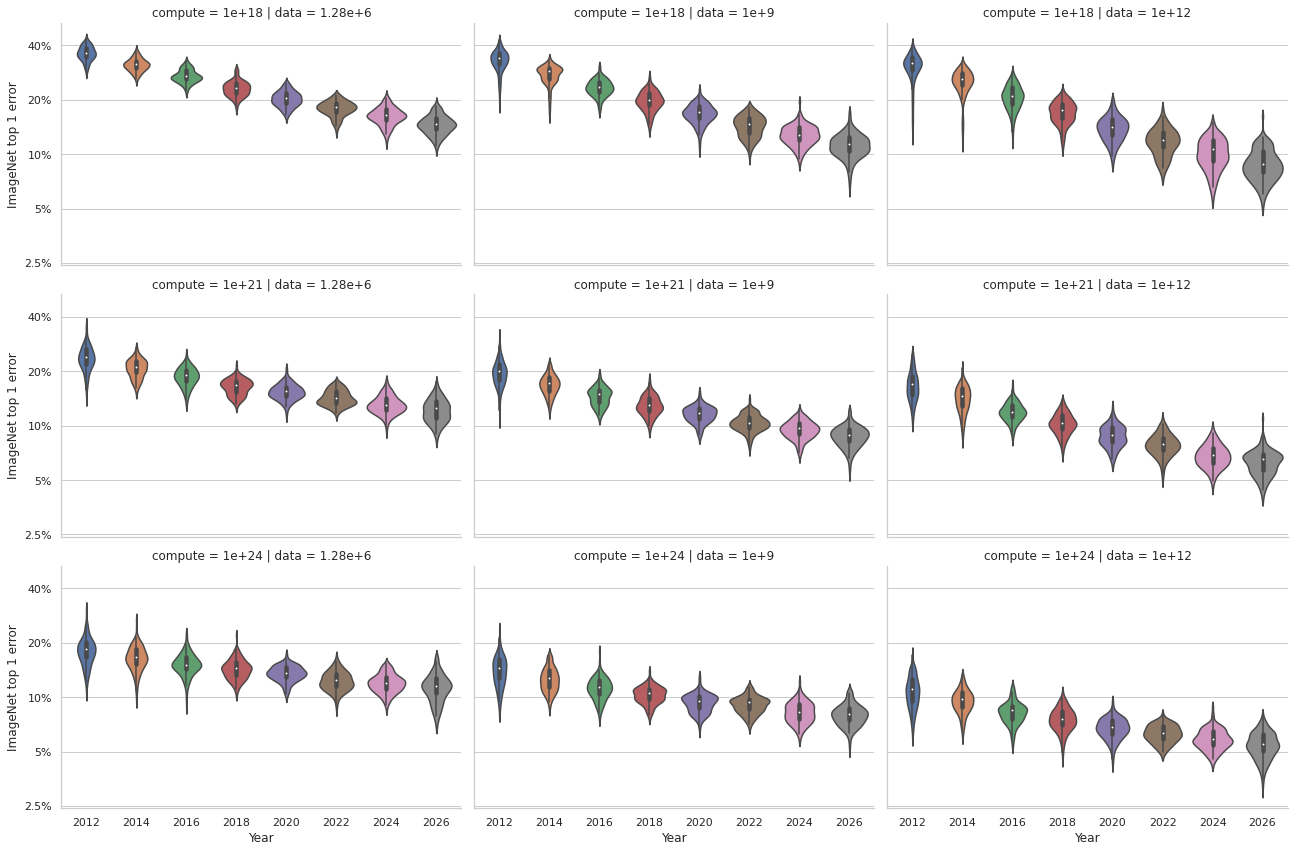

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import seaborn as sns

sns.set_theme(style="whitegrid")

df_visual = {"Year": [], "data": [], "compute": [], "ImageNet top 1 error": []}

data_list = ["1.28e+6", "1e+9", "1e+12"]
compute_list = ["1e+18", "1e+21", "1e+24"]
year_list =[2012,2014,2016,2018,2020,2022,2024,2026]

for data in data_list:
    for compute in compute_list:
        for year in year_list:
            sample = accuracy_model(year - 1900, year - 1900, float(data), float(compute), noisy=True)
            for q in sample:
                df_visual["Year"].append(year)
                df_visual["compute"].append(compute)
                df_visual["data"].append(data)
                df_visual["ImageNet top 1 error"].append(1-q)

df_visual = pd.DataFrame(df_visual)

g = sns.catplot(x="Year", y="ImageNet top 1 error", col="data", row="compute",
                data=df_visual, kind="violin", split=True,
                height=4, aspect=1.5)
g.set(yscale="log")
plt.yticks([0.4, 0.2, 0.1, 0.05, 0.025], ["40%", "20%", "10%", "5%", "2.5%"])

plt.savefig("violplot.pdf", bbox_inches='tight')
plt.show()
files.download("violplot.pdf") 
plt.close()

# Cross validation for prior

In [ ]:
w = len(df4)
steps = w

df2 = df4.copy()
df2["top_1_error"] = df2["top_1_error"].apply(lambda p: p/100)
df2["performance"] = df2["top_1_error"].apply(lambda p: 1 - p)

#left_out = [np.random.choice(range(w), size=1) for _ in range(steps)]
left_out = list(range(steps))
df_random_list = [df2.iloc[[k for k in range(w) if k != left_out[i]]] for i in range(steps)]

In [ ]:
#cross-validation

stdvs = [0.15, 0.12, 0.11, 0.1, 0.09, 0.08, 0.07,0.06, 0.05, 0.04, 0.03, 0.02]
stdv_other = 2

for stdev in stdvs:

  ir = 0 # this variable should always be set to zero in this part of the script! otherwise the log likelihood corrections will be computed incorrectly

  params_table = {"const_year": [], "beta_year": [], "beta_compute": [], "const_data": [], "beta_data": [], "beta_year_2": [], "sigma": []}
  log_likelihoods = []

  def regularizer(params):
    [const_year, beta_year, beta_compute, const_data, beta_data, beta_year_2, sigma] = params

    return norm_logpdf(params, mu = [0, 0, 0, 0, 0, 0, 0], sigma = [stdv_other, stdev, stdev, stdv_other, stdev, stdev, stdv_other])

  def llf_validation(params, year, compute, data, performance):
      [const_year, beta_year, beta_compute, const_data, beta_data, beta_year_2, sigma] = params
      sigma = np.exp(sigma)

      first_arg = const_year + beta_year * (year - 112) + beta_compute * (np.log(compute) - np.log(4.7e+17))
      second_arg = const_data + beta_year_2 * (year - 112) + beta_data * (np.log(data) - np.log(1e+6))

      return norm_logpdf_scalar(inv_sigmoid(performance), mu = inv_sigmoid(sigmoid(first_arg) * sigmoid(second_arg)), \
                                                        sigma = sigma) + log_correction(performance)

  def bootstrap_validation(df_random_list, i=0):
      df_random = df_random_list[i]

      error = np.array(df_random["top_1_error"], dtype=float)
      performance = 1 - error
      year = np.array(df_random["year"], dtype=float)
      compute = np.array(df_random["final_compute_estimate"], dtype=float)
      data = np.array(df_random["data"], dtype=float)

      n = len(error)

      def loss(params):
          [const_year, beta_year, beta_compute, const_data, beta_data, beta_year_2, sigma] = params
          sigma = np.exp(sigma)

          first_arg = const_year + beta_year * (year - 112) + beta_compute * (np.log(compute) - np.log(4.7e+17))
          second_arg = const_data + beta_year_2 * (year - 112) + beta_data * (np.log(data) - np.log(1e+6))

          #print(error)                                                                                
          rval = -norm_logpdf(inv_sigmoid(performance), mu = inv_sigmoid(sigmoid(first_arg) * sigmoid(second_arg)), \
                                                        sigma = np.array([sigma] * n))/len(performance) \
                -regularizer(params)/len(performance)

          return rval

      grad_loss = grad(loss)
      hess_loss = hessian(loss)
                                                    
      res = basinhopping(loss, x0=[1, 1e-1, 1e-1, 1, 1e-1, 1e-1, -3], minimizer_kwargs = {"method": "trust-ncg", "tol": 1e-10, "jac": grad_loss, "hess": hess_loss}, niter=2)
      return res, (-res.fun * len(performance) + np.sum([log_correction(p) for p in performance]))

  for i in range(steps):
      left_out_index = int(left_out[i])
      left_out_row = df2.iloc[left_out_index]

      res, llf = bootstrap_validation(df_random_list, i)
      const_year, beta_year, beta_compute, const_data, beta_data, beta_year_2, sigma = res.x

      params_table["const_year"].append(const_year)
      params_table["beta_year"].append(beta_year)
      params_table["beta_year_2"].append(beta_year_2)
      params_table["beta_compute"].append(beta_compute)
      params_table["const_data"].append(const_data)
      params_table["beta_data"].append(beta_data)
      params_table["sigma"].append(sigma)

      log_likelihoods.append(llf_validation(res.x, left_out_row["year"], left_out_row["final_compute_estimate"], \
                                                  left_out_row["data"], 1 - left_out_row["top_1_error"]))


  #print("Bootstrapping complete!")
  #print("\n")

  params_table_val = deepcopy(params_table)
  log_likelihoods_val = deepcopy(log_likelihoods)
  print(stdev)
  print(np.mean(log_likelihoods_val))
  print("\n")

KeyboardInterrupt: ignored

# Comparison to Hernandez, Brown (2020)

This tries to reproduce the results of Hernandez and Brown using an approach that fixes a performance threshold, and evaluates how much less compute is required to achieve that performance. Crucially, we consider a range of different thresholds to show the sensitivity of the estimates to the precise threshold.

In [ ]:
def closest_value(lst, K):
      
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]

In [ ]:
# Import the math module to use the geometric mean function
import math

accuracy_thresholds = [0.60,0.70,0.80,0.8, 0.84, 0.87]
years = [2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022]

for accuracy_threshold in accuracy_thresholds:

  compute_requirements_per_year = []
  for year in years:
    data_set_size = 1.28*10**6
    accuracy_result = []
    compute_range = []
    for i in range(1,2000):
      val = (1.1**i)*(10**3)
      compute_range.append(val)
      predicted_accuracy = accuracy_model(year-1900,year-1900,data_set_size,val)
      accuracy_result.append(predicted_accuracy)

    val=closest_value(accuracy_result,accuracy_threshold)
    index = accuracy_result.index(val)
    compute_required = compute_range[index]
    compute_requirements_per_year.append(compute_required)

  # Define a function to calculate the percentage decrease
  def decrease_factor(current, previous):
    return current  / previous 

  # Define a function to calculate the geometric mean of a list of numbers
  def geometric_mean(numbers):
    product = 1
    for number in numbers:
      product *= number
    return product ** (1 / len(numbers))

  # Define a list of decreasing numbers
  numbers = compute_requirements_per_year
  # Initialize an empty list to store the percentage decreases
  decrease_factors = []
  print("compute requirements for", accuracy_threshold, "for each of the years is", numbers)
  # Loop through the numbers and calculate the percentage decrease for each pair of consecutive numbers
  for i in range(1, len(numbers)):
    current = numbers[i]
    previous = numbers[i-1]
    decrease = decrease_factor(current, previous)
    decrease_factors.append(decrease)

  # Calculate the geometric mean of the percentage decreases
  geometric_mean = geometric_mean(decrease_factors)
  halving_time = -12*np.log(2)/(np.log(geometric_mean))

  # Print the result
  print(f"The compute-halving time for accuracy threshold {accuracy_threshold:.2f} every {halving_time:.2f} months")

NameError: ignored